#### Analysis of word embeddings
This script helps you to analyze whether fine-tuning with scrambled datasets lead the model to eventually reassociate word identities with tokens in the upper layers. Not the embedding layer!

In [1]:
from analysis_util import *
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data.sampler import RandomSampler, SequentialSampler
from torch.nn import CrossEntropyLoss
import torch.optim as optim
import torch.nn.functional as F

cache_dir = "../tmp/"
probing_results = {}

In [456]:
# task setups
task_name = "snli"
# random seeds
# WARNING: this may change your results as well. Try it a few different seeds.
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [457]:
SCRAMBLED_FILENAME_CONFIG = {
    "sst3" : "sst-tenary-corrupted-matched",
    "cola" : "cola-corrupted-matched",
    "mnli" : "mnli-corrupted-matched",
    "snli" : "snli-corrupted-matched",
    "mrpc" : "mrpc-corrupted-matched",
    "qnli" : "qnli-corrupted-matched",
    "conll2003" : "conll2003-corrupted-matched",
    "en_ewt" : "en_ewt-corrupted-matched"
}

In [458]:
if task_name == "conll2003":
    dataset = load_dataset("conll2003", cache_dir=cache_dir)
    train_df = dataset["train"]
    eval_df = dataset["validation"]
    test_df = dataset["test"]
elif task_name == "en_ewt":
    dataset = load_dataset("universal_dependencies", "en_ewt", cache_dir=cache_dir)
    train_df = dataset["train"]
    eval_df = dataset["validation"]
    test_df = dataset["test"]
else:
    # handle token data differently
    train_df = pd.read_csv(os.path.join(external_output_dirname, SCRAMBLED_FILENAME_CONFIG[task_name], 
                                        f"train.tsv"), 
                           delimiter="\t")
    eval_df = pd.read_csv(os.path.join(external_output_dirname, SCRAMBLED_FILENAME_CONFIG[task_name], 
                                       f"dev.tsv"), 
                          delimiter="\t")
    test_df = pd.read_csv(os.path.join(external_output_dirname, SCRAMBLED_FILENAME_CONFIG[task_name], 
                                       f"test.tsv"), 
                          delimiter="\t")

    train_df = Dataset.from_pandas(train_df)
    eval_df = Dataset.from_pandas(eval_df)
    test_df = Dataset.from_pandas(test_df)

In [459]:
print("**** Dataset Statistics ****")
print(f"training example = {len(train_df)}")
print(f"validation example = {len(eval_df)}")
print(f"testing example = {len(test_df)}")
print("****************************")

**** Dataset Statistics ****
training example = 550152
validation example = 10000
testing example = 10000
****************************


In [460]:
# we need to first get the swapping dictionary.
# this tokenizer helps you to get piece length for each token
modified_tokenizer = ModifiedBertTokenizer(
    vocab_file="../data-files/bert_vocab.txt")
modified_basic_tokenizer = ModifiedBasicTokenizer()

class WordIdentityProbe(nn.Module):
    def __init__(self, hidden_in, vocab_size):
        super(WordIdentityProbe, self).__init__()
        self.fc1 = nn.Linear(hidden_in, hidden_in)
        self.fc2 = nn.Linear(hidden_in,hidden_in)
        self.fc3 = nn.Linear(hidden_in,vocab_size)
        self.droput = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.droput(x)
        x = F.relu(self.fc2(x))
        x = self.droput(x)
        x = self.fc3(x)
        return x

def token_stats_mapping(task, example):
    
    # for tasks that have single sentence
    if task == "sst3" or task == "wiki-text" or task == "cola":
        original_sentence = example[TASK_CONFIG[task][0]]
        if original_sentence != None and original_sentence.strip() != "" and original_sentence.strip() != "None":
            if len(original_sentence.strip()) != 0:
                tokens, token_dict = modified_tokenizer.tokenize(original_sentence)
                for token, pieces in token_dict.items():
                    if token in token_frequency_map.keys():
                        token_frequency_map[token] = token_frequency_map[token] + 1
                    else:
                        token_frequency_map[token] = 1
                    _len = len(pieces)
                    if _len in token_by_length.keys():
                        if token not in token_by_length[_len]:
                            token_by_length[_len].append(token)
                    else:
                        token_by_length[_len] = [token]
    # for tasks that have two sentences
    elif task == "mrpc" or task == "mnli" or task == "snli" or task == "qnli":
        original_sentence = example[TASK_CONFIG[task][0]]
        if original_sentence != None and original_sentence.strip() != "" and original_sentence.strip() != "None":
            tokens, token_dict = modified_tokenizer.tokenize(original_sentence)
            for token, pieces in token_dict.items():
                if token in token_frequency_map.keys():
                    token_frequency_map[token] = token_frequency_map[token] + 1
                else:
                    token_frequency_map[token] = 1
                _len = len(pieces)
                if _len in token_by_length.keys():
                    if token not in token_by_length[_len]:
                        token_by_length[_len].append(token)
                else:
                    token_by_length[_len] = [token]
                
        original_sentence = example[TASK_CONFIG[task][1]]
        if original_sentence != None and original_sentence.strip() != "" and original_sentence.strip() != "None":
            tokens, token_dict = modified_tokenizer.tokenize(original_sentence)
            for token, pieces in token_dict.items():
                if token in token_frequency_map.keys():
                    token_frequency_map[token] = token_frequency_map[token] + 1
                else:
                    token_frequency_map[token] = 1
                _len = len(pieces)
                if _len in token_by_length.keys():
                    if token not in token_by_length[_len]:
                        token_by_length[_len].append(token)
                else:
                    token_by_length[_len] = [token]
    elif task == "conll2003" or task == "en_ewt":
        # we have the words already!
        tokens = example[TASK_CONFIG[task][0]]
        for token in tokens:
            if token in token_frequency_map.keys():
                token_frequency_map[token] = token_frequency_map[token] + 1
            else:
                token_frequency_map[token] = 1
            _len = 1 # all is one!
            if _len in token_by_length.keys():
                if token not in token_by_length[_len]:
                    token_by_length[_len].append(token)
            else:
                token_by_length[_len] = [token]
    else:
        print(f"task={task} not supported yet!")
    return example

token_by_length = {} # overwrite this everytime for a new dataset
token_frequency_map = {} # overwrite this everytime for a new dataset
train_df = train_df.map(partial(token_stats_mapping, task_name))
eval_df = eval_df.map(partial(token_stats_mapping, task_name))
test_df = test_df.map(partial(token_stats_mapping, task_name))
task_token_by_length = OrderedDict(token_by_length)
task_token_frequency_map = sorted(token_frequency_map.items(), key=operator.itemgetter(1), reverse=True)
task_token_frequency_map = OrderedDict(task_token_frequency_map)
# mismatch script
vocab_match_frequency_iv = \
    generate_vocab_match_frequency_iv(task_token_by_length, 
                                      task_token_frequency_map)

  8%|▊         | 1082/14337 [00:00<00:01, 10813.82it/s]

100%|██████████| 1/1 [00:00<00:00, 6775.94it/s]


In [461]:
# Loading models from fine-tuned models.
model_name_or_path = f"../{FILENAME_CONFIG[task_name]}-corrupted-matched-result/{SUBDIR_CONFIG[task_name]}-sample/"
cache_dir = "../tmp/"
finetuned_config = AutoConfig.from_pretrained(
    model_name_or_path,
    num_labels=NUM_LABELS[task_name],
    finetuning_task=task_name,
    cache_dir=cache_dir,
    output_hidden_states=True
)
tokenizer = AutoTokenizer.from_pretrained(
    model_name_or_path,
    use_fast=False,
    cache_dir=cache_dir
)
fintuned_model = AutoModelForSequenceClassification.from_pretrained(
    model_name_or_path,
    from_tf=False,
    config=finetuned_config,
    cache_dir=cache_dir
)

In [462]:
padding = "max_length"
sentence1_key, sentence2_key = TASK_CONFIG[task_name]
label_to_id = None
def preprocess_function(examples):
    # Tokenize the texts
    args = (
        (examples[sentence1_key],) if sentence2_key is None else (examples[sentence1_key], examples[sentence2_key])
    )
    result = tokenizer(*args, padding=padding, max_length=128, truncation=True)
    return result
train_df = train_df.map(preprocess_function, batched=True)
eval_df = eval_df.map(preprocess_function, batched=True)

#### CHANGE LAYER FOCUS HERE FOR THE DATASET

In [493]:
layer_focus = 10

In [494]:
train_df.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataloader = DataLoader(train_df, batch_size=32, shuffle=True)
token_map = {}
token_vocab = set([])
random_token_map = {}
map_to_token_vocab = set([])
for k, v in vocab_match_frequency_iv.items():
    token_map[v] = k
    token_vocab.add(v)
    map_to_token_vocab.add(k)
for k, v in vocab_match_frequency_iv.items():
    random_token_map[v] = random.sample(map_to_token_vocab, 1)[0]
eval_df.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
eval_dataloader = DataLoader(eval_df, batch_size=32, shuffle=True)

In [495]:
print("preparing training and dev set...")
word_label = []
random_word_label = []
word_embeddings = []
max_repr_learning_example = 100000
early_stop = False
for i, batch_dataloader in enumerate(tqdm(dataloader)):
    attention_mask = torch.tensor(batch_dataloader['attention_mask']).long()
    input_ids = torch.tensor(batch_dataloader['input_ids']).long()
    labels = torch.tensor(batch_dataloader['label']).long()
    outputs = fintuned_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    # we need to record embeddings that can be used to train our probes!
    batch_size = input_ids.size(0)
    for i in range(batch_size):
        for j in range(input_ids[i].size(0)):
            if input_ids[i,j] != 102 and input_ids[i,j] != 101 and input_ids[i,j] != 0:
                converted_token = tokenizer.convert_ids_to_tokens(input_ids[i,j].tolist())
                if converted_token in token_vocab:
                    word_label += [token_map[converted_token]]
                    random_word_label += [random_token_map[converted_token]]
                    word_embed = outputs.hidden_states[layer_focus][i,j].data.clone()
                    word_embeddings += [word_embed]
                    if len(word_embeddings) >= max_repr_learning_example:
                        early_stop = True
                        break
        if early_stop:
            break
    if early_stop:
        break

  0%|          | 0/17193 [00:00<?, ?it/s]

preparing training and dev set...


/afs/cs.stanford.edu/u/wuzhengx/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/afs/cs.stanford.edu/u/wuzhengx/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/afs/cs.stanford.edu/u/wuzhengx/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
  1%|          | 140/17193 [01:36<3:15:21,  1.45i

In [496]:
print("preparing testing set...")
train_vocab = set(word_label)
random_train_vocab = set(random_word_label)
test_word_label = []
test_word_embeddings = []
random_test_word_label = []
random_test_word_embeddings = []
for i, batch_dataloader in enumerate(tqdm(eval_dataloader)):
    attention_mask = torch.tensor(batch_dataloader['attention_mask']).long()
    input_ids = torch.tensor(batch_dataloader['input_ids']).long()
    labels = torch.tensor(batch_dataloader['label']).long()
    outputs = fintuned_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    # we need to record embeddings that can be used to train our probes!
    batch_size = input_ids.size(0)
    for i in range(batch_size):
        for j in range(input_ids[i].size(0)):
            if input_ids[i,j] != 102 and input_ids[i,j] != 101 and input_ids[i,j] != 0:
                converted_token = tokenizer.convert_ids_to_tokens(input_ids[i,j].tolist())
                if converted_token in token_vocab:
                    c_token = token_map[converted_token]
                    if c_token in train_vocab:
                        test_word_label += [c_token]
                        word_embed = outputs.hidden_states[layer_focus][i,j].data.clone()
                        test_word_embeddings += [word_embed]
                    random_c_token = random_token_map[converted_token] 
                    if random_c_token in random_train_vocab:
                        random_test_word_label += [random_c_token]
                        random_word_embed = outputs.hidden_states[layer_focus][i,j].data.clone()
                        random_test_word_embeddings += [random_word_embed]

  0%|          | 0/313 [00:00<?, ?it/s]/afs/cs.stanford.edu/u/wuzhengx/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/afs/cs.stanford.edu/u/wuzhengx/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/afs/cs.stanford.edu/u/wuzhengx/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is 

preparing testing set...


100%|██████████| 313/313 [03:29<00:00,  1.49it/s]


In [497]:
print("preparing dataloaders...")
# construct training and intraining dev data.
word_label_map = {}
label_index = 0
for word in (set(word_label)):
    word_label_map[word] = label_index
    label_index += 1
word_label_ids = []
for i in range(len(word_embeddings)):
    word_label_ids.append(word_label_map[word_label[i]])
word_label_ids = torch.tensor(word_label_ids).long()
if isinstance(word_embeddings, list):
    word_embeddings = torch.stack(word_embeddings, dim=0)
dataset = TensorDataset(word_embeddings, word_label_ids)
train_size = int(word_embeddings.shape[0]*0.9)
train_data, eval_data = \
    torch.utils.data.random_split(dataset, [train_size, word_embeddings.shape[0]-train_size], 
                                  generator=torch.Generator().manual_seed(seed))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=36)
eval_dataloader = DataLoader(eval_data, batch_size=128, shuffle=False)
# testing data
test_word_label_ids = []
for i in range(len(test_word_embeddings)):
    test_word_label_ids.append(word_label_map[test_word_label[i]])
if isinstance(test_word_embeddings, list):
    test_word_embeddings = torch.stack(test_word_embeddings, dim=0)
test_word_label_ids = torch.tensor(test_word_label_ids).long()
test_dataset = TensorDataset(test_word_embeddings, test_word_label_ids)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# random train + dev data
random_word_label_map = {}
label_index = 0
for word in (set(random_word_label)):
    random_word_label_map[word] = label_index
    label_index += 1
random_word_label_ids = []
for i in range(len(word_embeddings)):
    random_word_label_ids.append(random_word_label_map[random_word_label[i]])
random_word_label_ids = torch.tensor(random_word_label_ids).long()
random_dataset = TensorDataset(word_embeddings, random_word_label_ids)
random_train_data, random_eval_data = \
    torch.utils.data.random_split(random_dataset, [train_size, word_embeddings.shape[0]-train_size], 
                                  generator=torch.Generator().manual_seed(seed))
train_sampler = RandomSampler(random_train_data)
random_train_dataloader = DataLoader(random_train_data, sampler=train_sampler, batch_size=36)
random_eval_dataloader = DataLoader(random_eval_data, batch_size=128, shuffle=False)

# random test data
# testing data
random_test_word_label_ids = []
for i in range(len(random_test_word_embeddings)):
    random_test_word_label_ids.append(random_word_label_map[random_test_word_label[i]])
if isinstance(random_test_word_embeddings, list):
    random_test_word_embeddings = torch.stack(random_test_word_embeddings, dim=0)
random_test_word_label_ids = torch.tensor(random_test_word_label_ids).long()
random_test_dataset = TensorDataset(random_test_word_embeddings, random_test_word_label_ids)
random_test_dataloader = DataLoader(random_test_dataset, batch_size=128, shuffle=False)

preparing dataloaders...


In [498]:
model = WordIdentityProbe(768, len(word_label_map))
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_criterion = nn.NLLLoss()

In [499]:
# initial eval
model.eval()
eval_logits_scores = []
eval_y = []
with torch.no_grad():
    # pbar = tqdm(validation_dataloader, desc="Iteration")
    for step, batch in enumerate(eval_dataloader):
        x, y = batch
        logits = model(x)
        logits_scores = F.log_softmax(logits, dim=-1)
        eval_logits_scores += [logits_scores]
        eval_y += [y]
eval_logits_scores = torch.cat(eval_logits_scores, dim=0)
eval_y = torch.cat(eval_y, dim=0)

eval_logits_scores = eval_logits_scores.max(dim=-1)[1]
equal_targets = torch.eq(eval_y.data, eval_logits_scores.data).long()
match_sum_per_batch = equal_targets.sum()
batch_size = eval_logits_scores.size(0)
exact_match = 100. * match_sum_per_batch / batch_size

print(f"Eval Step={0}. Accuracy={exact_match}%.")

Eval Step=0. Accuracy=0.28999999165534973%.


In [500]:
# main training loop for the transformation matrix
# wandb.init(project="embedding-transformation", entity="wuzhengx")
num_train_epochs = 5
global_step = 0
logging_step_interval = 100
eval_step_interval = 500
for num_epoch in range(int(num_train_epochs)):
    print(f"Training Epoch={num_epoch}.")
    model.train()
    # pbar = tqdm(train_dataloader, desc="Iteration")
    for step, batch in enumerate(train_dataloader):

        x, y = batch
        logits = model(x)
        logits_scores = F.log_softmax(logits, dim=-1)
        loss = loss_criterion(logits_scores, y)
        loss.backward()
        optimizer.step()
        model.zero_grad()
        
        if global_step != 0 and global_step % logging_step_interval == 0:
            loss_to_print = round(loss.data.tolist(), 5)
            print(f"Training Step={global_step}. Loss={loss_to_print}.")
        
        if global_step != 0 and global_step % eval_step_interval == 0:
            model.eval()
            eval_logits_scores = []
            eval_y = []
            with torch.no_grad():
                # pbar = tqdm(validation_dataloader, desc="Iteration")
                for step, batch in enumerate(eval_dataloader):
                    x, y = batch
                    logits = model(x)
                    logits_scores = F.log_softmax(logits, dim=-1)
                    eval_logits_scores += [logits_scores]
                    eval_y += [y]
            eval_logits_scores = torch.cat(eval_logits_scores, dim=0)
            eval_y = torch.cat(eval_y, dim=0)
            
            eval_logits_scores = eval_logits_scores.max(dim=-1)[1]
            equal_targets = torch.eq(eval_y.data, eval_logits_scores.data).long()
            match_sum_per_batch = equal_targets.sum()
            batch_size = eval_logits_scores.size(0)
            exact_match = 100. * match_sum_per_batch / batch_size
                    
            print(f"Eval Step={global_step}. Accuracy={exact_match}%.")
            # wandb.log({'eval-loss': eval_loss, 'step': global_step})
        global_step += 1

Training Epoch=0.
Training Step=100. Loss=4.20677.
Training Step=200. Loss=3.86707.
Training Step=300. Loss=2.83325.
Training Step=400. Loss=2.86885.
Training Step=500. Loss=2.23399.
Eval Step=500. Accuracy=63.599998474121094%.
Training Step=600. Loss=1.62009.
Training Step=700. Loss=1.86472.
Training Step=800. Loss=2.58685.
Training Step=900. Loss=2.61849.
Training Step=1000. Loss=1.04726.
Eval Step=1000. Accuracy=73.79000091552734%.
Training Step=1100. Loss=2.30783.
Training Step=1200. Loss=1.70317.
Training Step=1300. Loss=2.25289.
Training Step=1400. Loss=1.87348.
Training Step=1500. Loss=2.0074.
Eval Step=1500. Accuracy=80.33000183105469%.
Training Step=1600. Loss=1.76222.
Training Step=1700. Loss=2.67682.
Training Step=1800. Loss=1.56511.
Training Step=1900. Loss=1.82003.
Training Step=2000. Loss=1.87258.
Eval Step=2000. Accuracy=84.12999725341797%.
Training Step=2100. Loss=1.52834.
Training Step=2200. Loss=0.96131.
Training Step=2300. Loss=0.83482.
Training Step=2400. Loss=1.034

In [501]:
# initial eval
model.eval()
eval_logits_scores = []
eval_y = []
with torch.no_grad():
    # pbar = tqdm(validation_dataloader, desc="Iteration")
    for step, batch in enumerate(test_dataloader):
        x, y = batch
        logits = model(x)
        logits_scores = F.log_softmax(logits, dim=-1)
        eval_logits_scores += [logits_scores]
        eval_y += [y]
eval_logits_scores = torch.cat(eval_logits_scores, dim=0)
eval_y = torch.cat(eval_y, dim=0)

eval_logits_scores = eval_logits_scores.max(dim=-1)[1]
equal_targets = torch.eq(eval_y.data, eval_logits_scores.data).long()
match_sum_per_batch = equal_targets.sum()
batch_size = eval_logits_scores.size(0)
test_exact_match = 100. * match_sum_per_batch / batch_size

print(f"Test Accuracy={test_exact_match}%.")

Test Accuracy=98.77639770507812%.


In [502]:
# we also need to have the controlled condition where
# we ask the probe to predict random label assigned.
random_model = WordIdentityProbe(768, len(word_label_map))
optimizer = optim.Adam(random_model.parameters(), lr=1e-4)
loss_criterion = nn.NLLLoss()

In [503]:
# initial eval
random_model.eval()
eval_logits_scores = []
eval_y = []
with torch.no_grad():
    # pbar = tqdm(validation_dataloader, desc="Iteration")
    for step, batch in enumerate(random_eval_dataloader):
        x, y = batch
        logits = random_model(x)
        logits_scores = F.log_softmax(logits, dim=-1)
        eval_logits_scores += [logits_scores]
        eval_y += [y]
eval_logits_scores = torch.cat(eval_logits_scores, dim=0)
eval_y = torch.cat(eval_y, dim=0)

eval_logits_scores = eval_logits_scores.max(dim=-1)[1]
equal_targets = torch.eq(eval_y.data, eval_logits_scores.data).long()
match_sum_per_batch = equal_targets.sum()
batch_size = eval_logits_scores.size(0)
exact_match = 100. * match_sum_per_batch / batch_size

print(f"Eval Step={0}. Accuracy={exact_match}%.")

Eval Step=0. Accuracy=0.07000000029802322%.


In [504]:
# main training loop for the transformation matrix
# wandb.init(project="embedding-transformation", entity="wuzhengx")
num_train_epochs = 5
global_step = 0
logging_step_interval = 100
eval_step_interval = 500
for num_epoch in range(int(num_train_epochs)):
    print(f"Training Epoch={num_epoch}.")
    random_model.train()
    # pbar = tqdm(train_dataloader, desc="Iteration")
    for step, batch in enumerate(random_train_dataloader):

        x, y = batch
        logits = random_model(x)
        logits_scores = F.log_softmax(logits, dim=-1)
        loss = loss_criterion(logits_scores, y)
        loss.backward()
        optimizer.step()
        random_model.zero_grad()
        
        if global_step != 0 and global_step % logging_step_interval == 0:
            loss_to_print = round(loss.data.tolist(), 5)
            print(f"Training Step={global_step}. Loss={loss_to_print}.")
        
        if global_step != 0 and global_step % eval_step_interval == 0:
            random_model.eval()
            eval_logits_scores = []
            eval_y = []
            with torch.no_grad():
                # pbar = tqdm(validation_dataloader, desc="Iteration")
                for step, batch in enumerate(random_eval_dataloader):
                    x, y = batch
                    logits = random_model(x)
                    logits_scores = F.log_softmax(logits, dim=-1)
                    eval_logits_scores += [logits_scores]
                    eval_y += [y]
            eval_logits_scores = torch.cat(eval_logits_scores, dim=0)
            eval_y = torch.cat(eval_y, dim=0)
            
            eval_logits_scores = eval_logits_scores.max(dim=-1)[1]
            equal_targets = torch.eq(eval_y.data, eval_logits_scores.data).long()
            match_sum_per_batch = equal_targets.sum()
            batch_size = eval_logits_scores.size(0)
            exact_match = 100. * match_sum_per_batch / batch_size
                    
            print(f"Eval Step={global_step}. Accuracy={exact_match}%.")
            # wandb.log({'eval-loss': eval_loss, 'step': global_step})
        global_step += 1

Training Epoch=0.
Training Step=100. Loss=5.07944.
Training Step=200. Loss=2.66501.
Training Step=300. Loss=3.4494.
Training Step=400. Loss=2.79385.
Training Step=500. Loss=1.31301.
Eval Step=500. Accuracy=63.400001525878906%.
Training Step=600. Loss=2.6226.
Training Step=700. Loss=3.15808.
Training Step=800. Loss=1.92375.
Training Step=900. Loss=2.99167.
Training Step=1000. Loss=1.80854.
Eval Step=1000. Accuracy=73.72000122070312%.
Training Step=1100. Loss=2.5768.
Training Step=1200. Loss=2.02004.
Training Step=1300. Loss=1.43251.
Training Step=1400. Loss=2.00105.
Training Step=1500. Loss=1.75922.
Eval Step=1500. Accuracy=80.22000122070312%.
Training Step=1600. Loss=1.13234.
Training Step=1700. Loss=3.45118.
Training Step=1800. Loss=1.60335.
Training Step=1900. Loss=0.85382.
Training Step=2000. Loss=1.26124.
Eval Step=2000. Accuracy=83.72000122070312%.
Training Step=2100. Loss=1.60779.
Training Step=2200. Loss=1.87757.
Training Step=2300. Loss=1.3242.
Training Step=2400. Loss=0.68668.

In [505]:
# initial eval
random_model.eval()
eval_logits_scores = []
eval_y = []
with torch.no_grad():
    # pbar = tqdm(validation_dataloader, desc="Iteration")
    for step, batch in enumerate(random_eval_dataloader):
        x, y = batch
        logits = random_model(x)
        logits_scores = F.log_softmax(logits, dim=-1)
        eval_logits_scores += [logits_scores]
        eval_y += [y]
eval_logits_scores = torch.cat(eval_logits_scores, dim=0)
eval_y = torch.cat(eval_y, dim=0)

eval_logits_scores = eval_logits_scores.max(dim=-1)[1]
equal_targets = torch.eq(eval_y.data, eval_logits_scores.data).long()
match_sum_per_batch = equal_targets.sum()
batch_size = eval_logits_scores.size(0)
random_test_exact_match = 100. * match_sum_per_batch / batch_size

print(f"Test Accuracy={exact_match}%.")

Test Accuracy=97.19000244140625%.


In [506]:
# Mannually record the numbers
if task_name in probing_results.keys():
    probing_results[task_name][layer_focus] = {
        "probe" : test_exact_match,
        "control" : random_test_exact_match,
    }
else:
    probing_results[task_name] = {}
    probing_results[task_name][layer_focus] = {
        "probe" : test_exact_match,
        "control" : random_test_exact_match,
    }

In [507]:
probing_results

{'sst3': {12: {'probe': tensor(76.2760), 'control': tensor(70.2500)},
  10: {'probe': tensor(92.9455), 'control': tensor(90.1600)},
  8: {'probe': tensor(96.7933), 'control': tensor(94.3600)},
  6: {'probe': tensor(98.4462), 'control': tensor(95.9700)},
  4: {'probe': tensor(99.1175), 'control': tensor(96.9600)},
  2: {'probe': tensor(99.3165), 'control': tensor(97.6900)},
  1: {'probe': tensor(99.6584), 'control': tensor(97.5000)}},
 'snli': {12: {'probe': tensor(97.8575), 'control': tensor(96.1300)},
  8: {'probe': tensor(99.3496), 'control': tensor(97.2700)},
  4: {'probe': tensor(99.7766), 'control': tensor(98.1000)},
  1: {'probe': tensor(99.8266), 'control': tensor(98.1200)},
  2: {'probe': tensor(99.8486), 'control': tensor(98.1200)},
  6: {'probe': tensor(99.6265), 'control': tensor(97.5600)},
  10: {'probe': tensor(98.7764), 'control': tensor(97.3200)}},
 'qnli': {12: {'probe': tensor(92.2145), 'control': tensor(89.5900)},
  8: {'probe': tensor(97.3091), 'control': tensor(93.9

#### Plot the results
Note that you have to run code blocks above iteratively till to fetch all results you want.

In [512]:
layers = [1, 2, 4, 6, 8, 10, 12] # all the hidden states we are interested in.
to_plot_data = {}
for task, task_data in probing_results.items():
    # find the max and set it to 100 percentage.
    task_max = -1
    for l in layers:
        l_max = max(task_data[l]["probe"], task_data[l]["control"])
        task_max = max(l_max, task_max)
    task_max = task_max.tolist()
    probe = []
    control = []
    for l in layers:
        probe += [task_data[l]["probe"].tolist()/task_max]
        control += [task_data[l]["control"].tolist()/task_max]
    to_plot_data[task] = {
        "probe": probe,
        "control": control,
    }

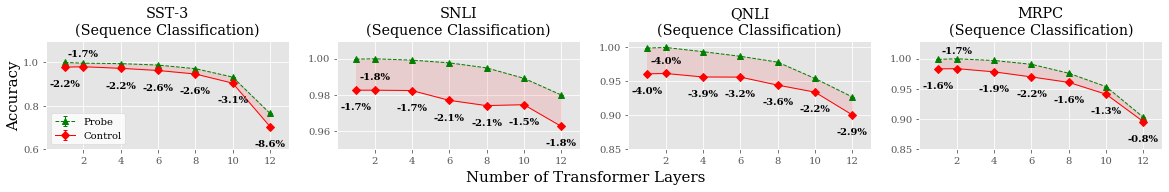

In [563]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams["font.family"] = "DejaVu Serif"
font = {'family' : 'DejaVu Serif',
        'size'   : 10}
plt.rc('font', **font)
fig, axs = plt.subplots(1, 4, figsize=(20, 2))
x_labels = [2,4,6,8,10,12]
x = [1,2,4,6,8,10,12]

axs[0].title.set_text('SST-3\n(Sequence Classification)')
axs[0].set_xlim(0,13)
axs[0].set_xticks(x_labels)
axs[0].errorbar(x, to_plot_data["sst3"]["probe"], linewidth=1, yerr=[0.00,0.00,0.00,0.00,0.00,0.00,0.00],
                   color="green", linestyle="--", marker="^", markersize=6, 
                   capsize=2, capthick=1, ecolor='g', label="Probe")
axs[0].errorbar(x, to_plot_data["sst3"]["control"], linewidth=1, yerr=[0.00,0.00,0.00,0.00,0.00,0.00,0.00],
                   color="red", marker="D", markersize=6, 
                   capsize=2, capthick=1, ecolor='r', label="Control")
axs[0].legend(facecolor="white", loc="lower left")
axs[0].fill_between(x, to_plot_data["sst3"]["probe"], to_plot_data["sst3"]["control"], alpha=0.1, color="r")    
#annotate
for m in range(0, len(to_plot_data["sst3"]["probe"])):
    diss_perc = round((to_plot_data["sst3"]["control"][m]-to_plot_data["sst3"]["probe"][m])*100/to_plot_data["sst3"]["control"][m], 1)
    if m != 1:
        axs[0].annotate(f'{diss_perc}%', xy =(x[m], to_plot_data["sst3"]["control"][m]), 
                           textcoords="offset points", # how to position the text
                           xytext=(0,-20), # distance from text to points (x,y)
                           ha='center', weight='bold')
    else:
        axs[0].annotate(f'{diss_perc}%', xy =(x[m], to_plot_data["sst3"]["control"][m]), 
                           textcoords="offset points", # how to position the text
                           xytext=(0,10), # distance from text to points (x,y)
                           ha='center', weight='bold')
axs[0].set_ylim(0.60, 1.1)
    
axs[1].title.set_text('SNLI\n(Sequence Classification)')
axs[1].set_xlim(0,13)
axs[1].set_xticks(x_labels)
axs[1].errorbar(x, to_plot_data["snli"]["probe"], linewidth=1, yerr=[0.00,0.00,0.00,0.00,0.00,0.00,0.00],
                   color="green", linestyle="--", marker="^", markersize=6, 
                   capsize=2, capthick=1, ecolor='g')
axs[1].errorbar(x, to_plot_data["snli"]["control"], linewidth=1, yerr=[0.00,0.00,0.00,0.00,0.00,0.00,0.00],
                   color="red", marker="D", markersize=6, 
                   capsize=2, capthick=1, ecolor='r')
axs[1].fill_between(x, to_plot_data["snli"]["probe"], to_plot_data["snli"]["control"], alpha=0.1, color="r")    
#annotate
for m in range(0, len(to_plot_data["snli"]["probe"])):
    diss_perc = round((to_plot_data["snli"]["control"][m]-to_plot_data["snli"]["probe"][m])*100/to_plot_data["snli"]["control"][m], 1)
    if m != 1:
        axs[1].annotate(f'{diss_perc}%', xy =(x[m], to_plot_data["snli"]["control"][m]), 
                           textcoords="offset points", # how to position the text
                           xytext=(0,-20), # distance from text to points (x,y)
                           ha='center', weight='bold')
    else:
        axs[1].annotate(f'{diss_perc}%', xy =(x[m], to_plot_data["snli"]["control"][m]), 
                           textcoords="offset points", # how to position the text
                           xytext=(0,10), # distance from text to points (x,y)
                           ha='center', weight='bold')
axs[1].set_ylim(0.95, 1.01)

axs[2].title.set_text('QNLI\n(Sequence Classification)')
axs[2].set_xlim(0,13)
axs[2].set_xticks(x_labels)
axs[2].errorbar(x, to_plot_data["qnli"]["probe"], linewidth=1, yerr=[0.00,0.00,0.00,0.00,0.00,0.00,0.00],
                   color="green", linestyle="--", marker="^", markersize=6, 
                   capsize=2, capthick=1, ecolor='g')
axs[2].errorbar(x, to_plot_data["qnli"]["control"], linewidth=1, yerr=[0.00,0.00,0.00,0.00,0.00,0.00,0.00],
                   color="red", marker="D", markersize=6, 
                   capsize=2, capthick=1, ecolor='r')
axs[2].fill_between(x, to_plot_data["qnli"]["probe"], to_plot_data["qnli"]["control"], alpha=0.1, color="r")    
#annotate
for m in range(0, len(to_plot_data["qnli"]["probe"])):
    diss_perc = round((to_plot_data["qnli"]["control"][m]-to_plot_data["qnli"]["probe"][m])*100/to_plot_data["qnli"]["control"][m], 1)
    if m != 1:
        axs[2].annotate(f'{diss_perc}%', xy =(x[m], to_plot_data["qnli"]["control"][m]), 
                           textcoords="offset points", # how to position the text
                           xytext=(0,-20), # distance from text to points (x,y)
                           ha='center', weight='bold')
    else:
        axs[2].annotate(f'{diss_perc}%', xy =(x[m], to_plot_data["qnli"]["control"][m]), 
                           textcoords="offset points", # how to position the text
                           xytext=(0,10), # distance from text to points (x,y)
                           ha='center', weight='bold')
axs[2].set_ylim(0.85, 1.01)

axs[3].title.set_text('MRPC\n(Sequence Classification)')
axs[3].set_xlim(0,13)
axs[3].set_xticks(x_labels)
axs[3].errorbar(x, to_plot_data["mrpc"]["probe"], linewidth=1, yerr=[0.00,0.00,0.00,0.00,0.00,0.00,0.00],
                   color="green", linestyle="--", marker="^", markersize=6, 
                   capsize=2, capthick=1, ecolor='g')
axs[3].errorbar(x, to_plot_data["mrpc"]["control"], linewidth=1, yerr=[0.00,0.00,0.00,0.00,0.00,0.00,0.00],
                   color="red", marker="D", markersize=6, 
                   capsize=2, capthick=1, ecolor='r')
axs[3].fill_between(x, to_plot_data["mrpc"]["probe"], to_plot_data["mrpc"]["control"], alpha=0.1, color="r")    
#annotate
for m in range(0, len(to_plot_data["mrpc"]["probe"])):
    diss_perc = round((to_plot_data["mrpc"]["control"][m]-to_plot_data["mrpc"]["probe"][m])*100/to_plot_data["mrpc"]["control"][m], 1)
    if m != 1:
        axs[3].annotate(f'{diss_perc}%', xy =(x[m], to_plot_data["mrpc"]["control"][m]), 
                           textcoords="offset points", # how to position the text
                           xytext=(0,-20), # distance from text to points (x,y)
                           ha='center', weight='bold')
    else:
        axs[3].annotate(f'{diss_perc}%', xy =(x[m], to_plot_data["mrpc"]["control"][m]), 
                           textcoords="offset points", # how to position the text
                           xytext=(0,15), # distance from text to points (x,y)
                           ha='center', weight='bold')
axs[3].set_ylim(0.85, 1.03)
fig.text(0.5, -0.1, 'Number of Transformer Layers', ha='center', size=15)
fig.text(0.098, 0.5, 'Selectivity', va='center', rotation='vertical', size=15)
# plt.show()
plt.savefig("../data-files/layer-control-probe-result.png",dpi=1000,bbox_inches='tight')

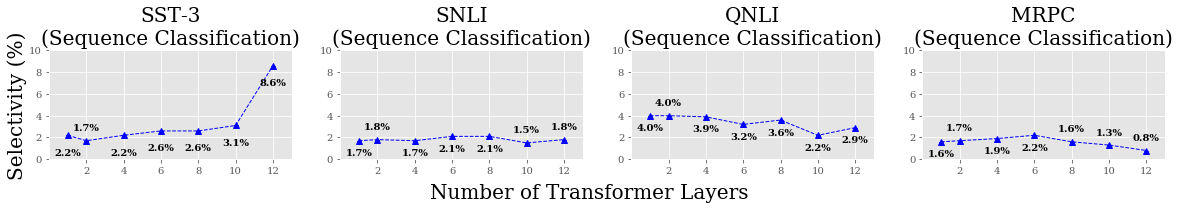

In [600]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams["font.family"] = "DejaVu Serif"
font = {'family' : 'DejaVu Serif',
        'size'   : 10}
plt.rc('font', **font)
fig, axs = plt.subplots(1, 4, figsize=(20, 2))
x_labels = [2,4,6,8,10,12]
x = [1,2,4,6,8,10,12]

axs[0].set_title('SST-3\n(Sequence Classification)', fontsize=20)
axs[0].set_xlim(0,13)
axs[0].set_xticks(x_labels)
selectivity_scores = []
for m in range(0, len(to_plot_data["sst3"]["probe"])):
    diss_perc = -1*round((to_plot_data["sst3"]["control"][m]-to_plot_data["sst3"]["probe"][m])*100/to_plot_data["sst3"]["control"][m], 1)
    selectivity_scores += [diss_perc]
axs[0].errorbar(x, selectivity_scores, linewidth=1, yerr=[0.00,0.00,0.00,0.00,0.00,0.00,0.00],
                   color="blue", linestyle="--", marker="^", markersize=6, 
                   capsize=2, capthick=1, ecolor='b')
#annotate
for m in range(0, len(to_plot_data["sst3"]["probe"])):
    if m != 1:
        axs[0].annotate(f'{selectivity_scores[m]}%', xy =(x[m], selectivity_scores[m]), 
                           textcoords="offset points", # how to position the text
                           xytext=(0,-20), # distance from text to points (x,y)
                           ha='center', weight='bold')
    else:
        axs[0].annotate(f'{selectivity_scores[m]}%', xy =(x[m], selectivity_scores[m]), 
                           textcoords="offset points", # how to position the text
                           xytext=(0,10), # distance from text to points (x,y)
                           ha='center', weight='bold')
axs[0].set_ylim(0.00, 10.00)
    
axs[1].set_title('SNLI\n(Sequence Classification)', fontsize=20)
axs[1].set_xlim(0,13)
axs[1].set_xticks(x_labels)
selectivity_scores = []
for m in range(0, len(to_plot_data["snli"]["probe"])):
    diss_perc = -1*round((to_plot_data["snli"]["control"][m]-to_plot_data["snli"]["probe"][m])*100/to_plot_data["snli"]["control"][m], 1)
    selectivity_scores += [diss_perc]
axs[1].errorbar(x, selectivity_scores, linewidth=1, yerr=[0.00,0.00,0.00,0.00,0.00,0.00,0.00],
                   color="blue", linestyle="--", marker="^", markersize=6, 
                   capsize=2, capthick=1, ecolor='b')
#annotate
for m in range(0, len(to_plot_data["snli"]["probe"])):
    if m != 1 and m != 5 and m != 6:
        axs[1].annotate(f'{selectivity_scores[m]}%', xy =(x[m], selectivity_scores[m]), 
                           textcoords="offset points", # how to position the text
                           xytext=(0,-15), # distance from text to points (x,y)
                           ha='center', weight='bold')
    else:
        axs[1].annotate(f'{selectivity_scores[m]}%', xy =(x[m], selectivity_scores[m]), 
                           textcoords="offset points", # how to position the text
                           xytext=(0,10), # distance from text to points (x,y)
                           ha='center', weight='bold')
axs[1].set_ylim(0.00, 10.00)

axs[2].set_title('QNLI\n(Sequence Classification)', fontsize=20)
axs[2].set_xlim(0,13)
axs[2].set_xticks(x_labels)
selectivity_scores = []
for m in range(0, len(to_plot_data["qnli"]["probe"])):
    diss_perc = -1*round((to_plot_data["qnli"]["control"][m]-to_plot_data["qnli"]["probe"][m])*100/to_plot_data["qnli"]["control"][m], 1)
    selectivity_scores += [diss_perc]
axs[2].errorbar(x, selectivity_scores, linewidth=1, yerr=[0.00,0.00,0.00,0.00,0.00,0.00,0.00],
                   color="blue", linestyle="--", marker="^", markersize=6, 
                   capsize=2, capthick=1, ecolor='b')
#annotate
for m in range(0, len(to_plot_data["qnli"]["probe"])):
    if m != 1:
        axs[2].annotate(f'{selectivity_scores[m]}%', xy =(x[m], selectivity_scores[m]), 
                           textcoords="offset points", # how to position the text
                           xytext=(0,-15), # distance from text to points (x,y)
                           ha='center', weight='bold')
    else:
        axs[2].annotate(f'{selectivity_scores[m]}%', xy =(x[m], selectivity_scores[m]), 
                           textcoords="offset points", # how to position the text
                           xytext=(0,10), # distance from text to points (x,y)
                           ha='center', weight='bold')
axs[2].set_ylim(0.00, 10.00)

axs[3].set_title('MRPC\n(Sequence Classification)', fontsize=20)
axs[3].set_xlim(0,13)
axs[3].set_xticks(x_labels)
selectivity_scores = []
for m in range(0, len(to_plot_data["mrpc"]["probe"])):
    diss_perc = -1*round((to_plot_data["mrpc"]["control"][m]-to_plot_data["mrpc"]["probe"][m])*100/to_plot_data["mrpc"]["control"][m], 1)
    selectivity_scores += [diss_perc]
axs[3].errorbar(x, selectivity_scores, linewidth=1, yerr=[0.00,0.00,0.00,0.00,0.00,0.00,0.00],
                   color="blue", linestyle="--", marker="^", markersize=6, 
                   capsize=2, capthick=1, ecolor='b')
#annotate
for m in range(0, len(to_plot_data["mrpc"]["probe"])):
    if m != 1 and m != 4 and m != 5 and m != 6:
        axs[3].annotate(f'{selectivity_scores[m]}%', xy =(x[m], selectivity_scores[m]), 
                           textcoords="offset points", # how to position the text
                           xytext=(0,-15), # distance from text to points (x,y)
                           ha='center', weight='bold')
    else:
        axs[3].annotate(f'{selectivity_scores[m]}%', xy =(x[m], selectivity_scores[m]), 
                           textcoords="offset points", # how to position the text
                           xytext=(0,10), # distance from text to points (x,y)
                           ha='center', weight='bold')
axs[3].set_ylim(0.00, 10.00)

fig.text(0.5, -0.15, 'Number of Transformer Layers', ha='center', size=20)
fig.text(0.096, 0.5, 'Selectivity (%)', va='center', rotation='vertical', size=20)
# plt.show()
plt.savefig("../data-files/layer-control-probe-result.png",dpi=1000,bbox_inches='tight')